<a href="https://colab.research.google.com/github/CyberMaryVer/llm-docs-comparison/blob/master/legal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Prerequisites](#scrollTo=sRyh9RVwRjWk)

>[Load data](#scrollTo=NoIMMX0YvFKf)

>[Document Comparison Approaches](#scrollTo=iRf9kogKO6_9)

>>[Base approach](#scrollTo=Q7N8mqa5ivsF)

>>[RAG approach](#scrollTo=Dy20d26YorHb)

>[Results](#scrollTo=e_VRQrz-cn_3)

>>[Base Approach Results](#scrollTo=YHyHS8lXb4Cu)

>>[RAG Approach Results](#scrollTo=bz5sj7H2b_vd)

>[Evaluation of results](#scrollTo=S4_2inAheobv)

>[Summary:](#scrollTo=w5P6Pl-vE_lF)

>>[Comparing Approaches: Base vs. RAG](#scrollTo=w5P6Pl-vE_lF)

>>>[Base Approach](#scrollTo=w5P6Pl-vE_lF)

>>>[RAG Approach](#scrollTo=w5P6Pl-vE_lF)



# 0. Prerequisites

In [3]:
#@markdown ###🔃 Install requirements
! pip install -qqq langchain
! pip install -qqq openai
! pip install -qqq langchain_openai
# ! pip install python-docx
! pip install -qqq docx2txt
! pip install -Uqqq langchain-community

from IPython.display import clear_output
import ipywidgets as widgets
import os

def inf(msg='\u2714 Done', style='success', wdth='50px'):
    clear_output()
    inf = widgets.Button(description=msg,
                         disabled=True,
                         button_style=style,
                         layout=widgets.Layout(min_width=wdth))
    display(inf)

clear_output()

In [4]:
import openai
import os

openai.api_key = "" #@param {type: "string"}

#@markdown Show available models
MODEL_TO_CHECK = "gpt-4o" #@param ["gpt-4o", "gpt-4-vision-preview"]
PRINT_ALL = False #@param {type: "boolean"}

if not openai.api_key:
    raise ValueError("OpenAI API key is not set. Please set the 'OPENAI_API_KEY' environment variable.")

# Check if the gpt-4 model is available
available_models = openai.models.list()
gpt_4_available = any(model.id == MODEL_TO_CHECK for model in available_models.data)

if gpt_4_available:
    print(f"{MODEL_TO_CHECK} is available for use.")
else:
    print(f"{MODEL_TO_CHECK} is not available for use.")

if PRINT_ALL:
  print("\n\033[096mAvailable models: \033[0m")
  for model in available_models.data:
      print(model.id)

gpt-4o is available for use.


# 1. Load data

In [5]:
! gdown 1Vlq7OgHfJC8xnWwUYXvB1JdJynJypxqk -O /content/doc1.docx
! gdown 1ZdGrmmcgvkcpX038ra81ryR5w3bltlKm -O /content/doc2.docx

Downloading...
From: https://drive.google.com/uc?id=1Vlq7OgHfJC8xnWwUYXvB1JdJynJypxqk
To: /content/doc1.docx
100% 92.1k/92.1k [00:00<00:00, 47.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZdGrmmcgvkcpX038ra81ryR5w3bltlKm
To: /content/doc2.docx
100% 110k/110k [00:00<00:00, 60.2MB/s]


In [130]:
#@markdown ###🔃 Load utils

import base64
import requests
from openai import OpenAI
from tqdm.notebook import tqdm_notebook as tqdm
import os
import re
import json
import random
import matplotlib.pyplot as plt
import numpy as np

client = OpenAI(api_key=openai.api_key)

# Function to send simple openai request
def ask_openai(prompt,
               model_name="gpt-4o",
               verbose=True,
               max_tokens=300):

    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {openai.api_key}"
    }

    payload = {
      "model": model_name,
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
          ]
        }
      ],
      "max_tokens": max_tokens
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    result = response.json()
    print(result) if verbose else None
    message = result['choices'][0]['message']['content']
    print(message) if verbose else None

    return message

def process_result(response):
    result = response.json()
    result = json.loads(result)
    return result['choices'][0]['message']['content']


def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    r = openai.embeddings.create(input=[text], model=model)
    return r.dict()['data'][0]['embedding']


def merge_jsons(jsons):
    merged_df_data = []
    missed_indexes = []
    for idx, json_str in enumerate(jsons):
        json_str = json_str.replace("```json", "").replace("```", "")
        try:
            json_data = json.loads(json_str)
        except ValueError:
            # print(f"Invalid JSON [{idx}]: {json_str[:1000]}")
            missed_indexes.append(idx)
            continue
        for key, value in json_data.items():
            if isinstance(value, dict):
                merged_df_data.append(value)

    return merged_df_data, missed_indexes

def merge_final(final_result):
    df_data = []
    missed_ids = []
    # clean json string
    final_result = re.sub(r'```json\n', '', final_result)
    final_result = re.sub(r'\n```', '', final_result)
    final_result = re.sub(r'```', '', final_result)
    final_result = re.sub(r'\n', '', final_result)
    try:
        json_data = json.loads(final_result)
        for key, value in json_data.items():
            if isinstance(value, dict):
                df_data.append(value)
            else:
                missed_ids.append(key)
        return df_data, missed_ids
    except ValueError:
        print("Invalid JSON")
        return [], []

def plot_vertical_bar_with_strips(values):
    fig, ax = plt.subplots(figsize=(3, 4))
    bar_width = 2
    for idx, value in enumerate(values):
        color = "red" if value > 0.18 else "green"
        # color = (value, 0, value)  # RGB, with blue channel set by the value
        ax.bar(0, 1, bottom=idx, width=bar_width, color=color, edgecolor='none')
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, len(values))
    ax.axis('off')
    plt.show()

# Document Comparison Approaches

When comparing two documents, two approaches can be employed: the Base approach and the Retrieval-Augmented Generation (RAG) approach.

## Base approach

- analyze each chunk
- extract meaningful info
- combine altogether into summary with key points
- compare two documents by their summaries

In [178]:
import pandas as pd
import docx2txt
from langchain import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.chat_models import ChatOpenAI
from langchain.document_loaders import Docx2txtLoader
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain, StuffDocumentsChain, LLMChain
from langchain.prompts import PromptTemplate
os.environ["OPENAI_API_KEY"] = openai.api_key

model_name = "gpt-4o"
llm = ChatOpenAI(model_name=model_name, openai_api_key=openai.api_key)
text_splitter = CharacterTextSplitter()

In [177]:
map_template = """
You are a legal assistant. Your task is to analyze the document and identify key points and meaningful information.
Focus on clauses, conditions, obligations, restrictions, dates, and other relevant details.
Provide a numbered list of key points.

DOCUMENT:

{docs}


Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)

reduce_template = """The following is set of summaries:
{docs}
You are a legal assistant. Take these and distill it into a final, consolidated summary of the main themes.
Focus on clauses, conditions, obligations, restrictions, dates, and other relevant details.

Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [176]:
map_chain = LLMChain(llm=llm, prompt=map_prompt)
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)
map_reduce_chain = MapReduceDocumentsChain(
    llm_chain=map_chain,
    reduce_documents_chain=reduce_documents_chain,
    document_variable_name="docs",
    return_intermediate_steps=False,
)

Summarize Document 1

In [179]:
text_loader = Docx2txtLoader(file_path='doc1.docx')
pages1 = text_loader.load_and_split(text_splitter)
result = map_reduce_chain.invoke(pages1)

Summarize Document 2

In [180]:
text_loader = Docx2txtLoader(file_path='doc2.docx')
pages2 = text_loader.load_and_split(text_splitter)
result2 = map_reduce_chain.invoke(pages2)

In [181]:
print(result['output_text'])

### Final Consolidated Summary of Main Themes

**Parties Involved:**
- **Madison Productions, LLC (Parent)**
- **Big Kahuna Holdings, Inc. (Merger Sub)**
- **Restoration Hardware, Inc. (Company)**

**Date of Agreement:** November 8, 2022

**Purpose:** Merger of Merger Sub into the Company, making the Company a wholly owned subsidiary of Parent.

### Key Clauses and Conditions:

**Merger Execution and Effective Time:**
- Effective upon filing the Certificate of Merger with the Delaware Secretary of State or at a specified later time.

**Closing Details:**
- Scheduled at Gibson, Dunn & Crutcher LLP, New York, on the third business day after fulfilling or waiving the conditions in Article VI.

**Effects of the Merger:**
- Surviving corporation acquires all assets and liabilities.
- Amendments to the Company's certificate of incorporation and bylaws.

**Directors and Officers:**
- Directors of Merger Sub become initial directors; current officers of the Company remain.

**Capital Stock Cha

In [199]:
compare_prompt = """
You are a legal assistant. Your task is to analyze two documents summaries and identify key differences.
Focus on clauses, conditions, obligations, restrictions, dates, and other relevant details.

Return following structure in the JSON format:
{"key_difference1": {"Document 1": "...", "Document 2": "...", "Legal Assistant comment" : "..."},
"key_difference2": {"Document 1": "...", "Document 2": "...", "Legal Assistant comment" : "..."},
...
}

DOCUMENT 1 SUMMARY:
{doc1}

DOCUMENT 2 SUMMARY:
{doc2}

Helpful Answer:"""

formatted_compare_prompt = compare_prompt.replace("{doc1}", result['output_text']).replace("{doc2}", result2['output_text'])

In [200]:
final_result1 = ask_openai(formatted_compare_prompt, model_name=model_name, max_tokens=4000, verbose=True)

{'id': 'chatcmpl-9ay2xFnn2ijp61XjsQ9qPMJll5kMm', 'object': 'chat.completion', 'created': 1718597655, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '```json\n{\n  "key_difference1": {\n    "Document 1": "Date of Agreement: November 8, 2022",\n    "Document 2": "Agreement Date: August 4, 2022",\n    "Legal Assistant comment": "The agreement dates differ by several months, with Document 1\'s agreement being later."\n  },\n  "key_difference2": {\n    "Document 1": "Purpose: Merger of Merger Sub into the Company, making the Company a wholly owned subsidiary of Parent.",\n    "Document 2": "Purpose: Consolidation of Merger Sub into iRobot Corporation, making iRobot a wholly-owned subsidiary of Amazon.",\n    "Legal Assistant comment": "While both documents describe a merger making the company a subsidiary, Document 2 specifies \'iRobot Corporation\' and \'Amazon\'."\n  },\n  "key_difference3": {\n    "Document 1": "Closing details mention 

In [201]:
with open('result1.json', 'w') as f:
    f.write(final_result1)

## RAG approach
- Split both documents to chunks with overlapping
- Vectorize Doc 2 to faiss index
- Iterate chunk by chunk through Doc 1, for each chunk find the nearest one in Doc 2
- Compare 2 chunks with LLM, extract only key differences
- Summarize all differences

In [65]:
! pip install faiss-gpu
# ! pip install faiss-cpu

In [61]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.faiss import FAISS
import requests

In [66]:
faiss_index = FAISS.from_documents(pages2, OpenAIEmbeddings())

In [187]:
original_chunk = pages1[5].page_content
original_chunk_embedding = get_embedding(original_chunk)
similar_chunks = faiss_index.similarity_search_with_score_by_vector(original_chunk_embedding, k=2)

print(f"\033[095mOriginal document:\033[0m\n{original_chunk}")

print(f"\n\033[095mSimilar chunks:\033[0m [{len(similar_chunks)}]")
for i, (schunk, score) in enumerate(similar_chunks):
    print(f"\033[096mChunk {i} [SCORE: {score}]:\033[0m")
    print(schunk.page_content)

Original document:
(f) Investment of Exchange Fund. The Paying Agent shall invest all cash included in the Exchange Fund as reasonably directed by Parent; provided, however, that any investment of such cash shall be limited to direct short-term obligations of, or short-term obligations fully guaranteed as to principal and interest by, the U.S. government or in commercial paper obligations rated P-1 or A-1 or better by Moody’s Investors Service, Inc. or Standard & Poor’s Rating Services, a division of The McGraw-Hill Companies, Inc., respectively, or in certificates of deposit, bank repurchase agreements or banker’s acceptances of commercial banks with capital exceeding $1 billion (based on the most recent financial statements of such bank which are then publicly available). Any interest and other income resulting from such investments shall be paid to Parent, upon demand. 

(g) Lost Certificates. In the case of any Certificate or any certificate representing Rollover Shares that has be

In [188]:
compare_prompt1 = """
You are a legal assistant. Your task is to analyze two documents excerpts and identify key differences.
If one document contains some information and another does not, mention it in the output, e.g.: "Document 2": "no information"
Focus on clauses, conditions, obligations, restrictions, dates, and other relevant details.
Mention only KEY differences from the legal assistant perspective. If there are no such KEY differences, mention it in the output, e.g.: "Legal Assistant comment" : "no KEY differences"

Return following structure in the JSON format:
{"key_difference1": {"Document 1": "...", "Document 2": "...", "Legal Assistant comment" : "..."},
"key_difference2": {"Document 1": "...", "Document 2": "...", "Legal Assistant comment" : "..."},
...
}

Return only JSON string! Do not return anything else.

DOCUMENT 1 SUMMARY:
{chunk1_1}

DOCUMENT 2 SUMMARY:
{chunk2_1}

{chunk2_2}

Helpful Answer:"""

In [133]:
from tqdm.notebook import tqdm_notebook as tqdm

model_name = "gpt-3.5-turbo"

comparisons = []
similarities = []
for page in tqdm(pages1):
    chunk = page.page_content
    chunk_embedding = get_embedding(chunk)
    similar_chunks = faiss_index.similarity_search_with_score_by_vector(chunk_embedding, k=2)
    chunk2_1, score1 = similar_chunks[0][0].page_content, similar_chunks[0][1]
    chunk2_2, score2 = similar_chunks[1][0].page_content, similar_chunks[1][1]
    formatted_compare_prompt = compare_prompt1.replace("{chunk1_1}", chunk).\
                                               replace("{chunk2_1}", chunk2_1).\
                                               replace("{chunk2_2}", chunk2_2)

    final_result = ask_openai(formatted_compare_prompt, model_name=model_name, max_tokens=1000, verbose=False)
    comparisons.append(final_result)
    similarities.append(score1)

  0%|          | 0/63 [00:00<?, ?it/s]

Plot approximate location of differences

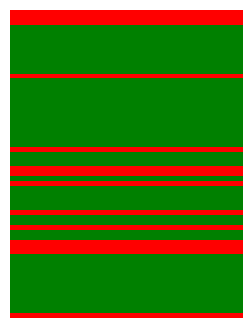

In [189]:
plot_vertical_bar_with_strips(similarities)

In [190]:
merged_comparisons, missed_ids = merge_jsons(comparisons)
df = pd.DataFrame(merged_comparisons)

In [191]:
print(missed_ids)
additional_info = "\n".join(str(comparisons[i]) for i in missed_ids)

[6]


In [192]:
df

,Document 1,Document 2,Legal Assistant comment
0,Includes information about the formation of a ...,No information,Document 1 provides additional details about t...
1,Specifies the condition that Rollover Particip...,No information,Document 1 contains specific conditions relate...
2,"Mentions making certain representations, warra...",No information,Document 1 highlights the importance of specif...
3,Provides details about the company continuing ...,Mentions the Surviving Corporation without det...,Document 1 elaborates on the status of the com...
4,Includes information about the cancellation of...,No information,Document 1 specifies the actions regarding Rol...
...,...,...,...
144,Section 8.8 Severability,no information,Document 1 addresses provisions regarding seve...
145,Section 8.9 Entire Agreement; No Third-Party B...,Section 9.7 Entire Agreement,Document 1 includes more detailed clauses abou...
146,Section 8.10 Headings,no information,Document 1 includes provisions regarding the h...
147,Defines terms such as 'Subsidiaries' and 'affi...,Defines terms 'Subsidiary' and 'Affiliate' in ...,Difference in the extent of defining terms rel...


In [193]:
df_doc1 = "\n".join(df.loc[df['Document 1'].apply(lambda x: str(x).lower() != 'no information'), 'Document 1'].tolist())
df_doc2 = "\n".join(df.loc[df['Document 2'].apply(lambda x: str(x).lower() != 'no information'), 'Document 2'].tolist())

In [194]:
len(df_doc1.split())

2655

In [195]:
compare_prompt2 = """
You are a legal assistant. Your task is to analyze two documents excerpts and identify key differences.
Focus on clauses, conditions, obligations, restrictions, dates, and other relevant details.
Mention only KEY differences from the legal assistant perspective.
Feel free to ignore irrelevant differences, such as broader lessons or norms that can be applied across cases.

Return following structure in the JSON format:
{"key_difference1": {"Document 1": "...", "Document 2": "...", "Legal Assistant comment" : "..."},
"key_difference2": {"Document 1": "...", "Document 2": "...", "Legal Assistant comment" : "..."},
...
}

Return only JSON string! Do not return anything else.

DOCUMENT 1 EXCERPTS:
{doc1}

DOCUMENT 2 EXCERPTS:
{doc2}

ADDITIONAL_INFO:
{additional_info}

Helpful Answer:"""

In [202]:
model_name = "gpt-4o"
formatted_compare_prompt = compare_prompt2.replace("{doc1}", df_doc1).replace("{doc2}", df_doc2,).replace("{additional_info}", additional_info)
final_result2 = ask_openai(formatted_compare_prompt, model_name=model_name, max_tokens=4000)

{'id': 'chatcmpl-9ay3cyRkwfQ1Kw6mTnPoPGpLv3diE', 'object': 'chat.completion', 'created': 1718597696, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '```json\n{\n  "key_difference1": {\n    "Document 1": "The Closing of the Merger shall take place at the offices of Gibson, Dunn & Crutcher LLP, 200 Park Avenue, New York, New York at 9:00 a.m., local time, on the third business day after the satisfaction or waiver of the conditions set forth in Article VI.",\n    "Document 2": "The date of the Closing is not specifically mentioned.",\n    "Legal Assistant comment": "Document 1 specifies the exact date and location for the Closing of the Merger, whereas Document 2 does not."\n  },\n  "key_difference2": {\n    "Document 1": "The officers of the Company immediately prior to the Effective Time shall be the initial officers of the Surviving Corporation.",\n    "Document 2": "Does not mention the officers of the Company becoming the initial of

In [203]:
with open('result2.json', 'w') as f:
    f.write(final_result2)

# Results

In [208]:
df_data, missed_ids1 = merge_final(final_result1)
df1 = pd.DataFrame(df_data)
df_data, missed_ids1 = merge_final(final_result2)
df2 = pd.DataFrame(df_data)

## Base Approach Results

In [209]:
df1

,Document 1,Document 2,Legal Assistant comment
0,"Date of Agreement: November 8, 2022","Agreement Date: August 4, 2022","The agreement dates differ by several months, ..."
1,Purpose: Merger of Merger Sub into the Company...,Purpose: Consolidation of Merger Sub into iRob...,While both documents describe a merger making ...
2,Closing details mention physical location: Sch...,Closing details occur virtually: Virtual closi...,Document 1 specifies an in-person closing loca...
3,Capital Stock Changes: Company Common Stock co...,Effect on Capital Stock: Company shares conver...,The per-share consideration differs significan...
4,Dissenting Shares: Shares demanding appraisal ...,Dissenting Shares: Included in general convers...,Document 1 provides a specific process for dis...
5,Employee Matters: Parent to honor existing pla...,Employee Benefits and Plans: Parent will provi...,"Both documents discuss employee benefits, but ..."
6,Stockholder Voting Requirements: Majority of o...,Approvals: Unanimous board approval from all p...,Document 1 specifies the percentages required ...
7,Solicitation and Acquisition Proposals: Compan...,Acquisition Proposals: Company must not solici...,Document 1 allows for solicitation within a sp...
8,Conditions to the Merger: Required stockholder...,Conditions to Effect the Merger: Stockholder A...,Both documents list conditions for the merger ...
9,"Termination Provisions: Mutual consent, unilat...",Termination Provisions: Mutual Consent and Tim...,Document 2 offers more detailed and varied ter...


## RAG Approach Results

In [210]:
df2

,Document 1,Document 2,Legal Assistant comment
0,The Closing of the Merger shall take place at ...,The date of the Closing is not specifically me...,Document 1 specifies the exact date and locati...
1,The officers of the Company immediately prior ...,Does not mention the officers of the Company b...,Document 1 includes specific provisions about ...
2,Rollover Participants must agree to contribute...,No mention of Rollover Participants or contrib...,Document 1 includes a specific tax-related con...
3,Section 3.21 Insurance: Annual premium amount ...,Contains provisions for obtaining 'tail' insur...,Document 1 provides specifics about existing i...
4,No shares of Company Preferred Stock issued or...,No Preferred Shares were outstanding.,Document 1 provides detailed information about...
5,Contains provisions regarding Excluded Parties...,No specific mention of provisions related to E...,Document 1 includes more detailed provisions o...
6,Procedure for surrender of Certificates or Boo...,Procedure for surrender of Share Certificates ...,"While both documents detail the procedure, Doc..."
7,Stock transfer books of the Company shall be c...,"From and after the Effective Time, there shall...",Both documents stipulate no further registrati...
8,Company agrees to hold all information provide...,No specific mention of confidentiality obligat...,Document 1 includes an explicit confidentialit...
9,Filing deadlines specified for the Proxy State...,Filing deadline for the Proxy Statement is wit...,Document 1 has a shorter filing deadline for t...


# Evaluation of results

Evaluation of results with LLM

In [216]:
def df_to_structured_text(df):
  txt = "LEGAL DOCUMENTS COMPARISON\n\n"
  for idx, row in df.iterrows():
      txt_line = "".join([f"{k}:\n{v}\n\n" for k, v in row.items()])
      txt += txt_line + "\n\n"
  return txt

In [221]:
compare_prompt_for_approaches = """
You are an expert in the legal field.
Below are two analyses of the same two documents, performed by two legal assistants.

Compare these takeaways and evaluate each assistant on the following four criteria, rating each from 1 to 10:

- Importance of identified issues (all key issues were found in both documents)
- Relevance of comments (all comments are relevant)
- Clarity of analysis (the analysis is clear and well-organized)
- Depth of insight (the analysis provides in-depth insights and understanding)

Finally, choose the best analysis and briefly explain your choice.

ANALYSIS OF FIRST ASSISTANT:
{doc1}

ANALYSIS OF SECOND ASSISTANT:
{doc2}

Helpful Answer:"""

In [224]:
formatted_compare_prompt = compare_prompt_for_approaches.replace("{doc1}", df_to_structured_text(df1)).replace("{doc2}", df_to_structured_text(df2))
llm_evaluation = ask_openai(formatted_compare_prompt, model_name=model_name, max_tokens=4000, verbose=False)

In [225]:
from IPython.display import display, Markdown
display(Markdown(llm_evaluation))

Below is a detailed evaluation of each assistant's analyses based on the mentioned criteria:

### Evaluation: First Assistant

#### Importance of Identified Issues: 10
The first assistant covered all significant aspects of both documents, including agreement dates, merger purposes, closing details, capital stock changes, dissenting shares, employee matters, stockholder voting requirements, solicitation and acquisition proposals, merger conditions, termination provisions, financial assurances, and insurance provisions.

#### Relevance of Comments: 9
All comments were relevant and properly contextualized the differences between the documents. However, some explanations could have been more elaborative to enhance understanding.

#### Clarity of Analysis: 9
The analysis was clear, well-organized, and concise, making it easy to follow. The structured breakdown by document and issue was particularly helpful.

#### Depth of Insight: 8
The assistant provided an in-depth comparison but could have offered a more detailed interpretation of the potential implications of these differences for interested parties.

### Evaluation: Second Assistant

#### Importance of Identified Issues: 7
The second assistant highlighted relevant issues, but some critical components (e.g., financial assurances, stockholder voting requirements, acquisition proposals, and dissenting shares) were noticeably absent from the analysis.

#### Relevance of Comments: 8
Comments were generally relevant but didn't always capture the broader impact or significance of the clauses. The focus was narrow, often pointing out differences without delving into potential implications.

#### Clarity of Analysis: 8
The analysis was clear, but the organization could have been improved. Listing specific sections of the documents without providing a comprehensive overview made the analysis harder to follow.

#### Depth of Insight: 6
There was a lack of depth in insights; the assistant pointed out differences without fully explaining their significance or potential consequences. Important issues like employee matters and stockholder voting were not covered in the same detailed manner as the first assistant.

### Conclusion

**Best Analysis: First Assistant**

**Reasoning:**
The first assistant's analysis was more comprehensive, included all key issues, and provided a balanced comparison of the documents. While there was room for slightly deeper insights, the breadth and organization of the analysis made it more helpful and informative. In contrast, the second assistant's analysis, though clear and relevant in parts, lacked the depth and coverage necessary for a thorough legal document comparison.

# **Summary**:

## Comparing Approaches: Base vs. RAG

When comparing two documents, two approaches can be employed: the Base approach and the Retrieval-Augmented Generation (RAG) approach. Here are the key takeaways from exploring both methods:

### Base Approach
**Pros:**

- Simplicity and Robustness: The Base approach is more straightforward and robust, making it a suitable option for language models (LLMs) with a very large context window.
- Consistency: This approach processes documents in a single, linear fashion, ensuring consistent results.

**Cons:**

- Time-Consuming: It takes a significant amount of time to process (24 minutes in this case).
- High Token Usage and Cost: The method requires more tokens, leading to higher processing costs.
- Lacks Explainability: The approach lacks intermediate steps, which can make it challenging to validate results or understand the reasoning behind the outcomes.

**How can be improved**

- Key Points List: Prepare a list of main key points to identify for each type of document. Summarize the document chunk by chunk, extracting information according to this list. This will significantly reduce cost and probably increase accuracy for these key issues.

  FYI: This method may face problems if there is a big variety of possible key issues.

### RAG Approach
**Pros:**

- Intermediate Results: The RAG approach consists of several steps, providing intermediate results that can be used for validation and better explainability.
- Faster and Cost-Effective: This method is faster and cheaper because it doesn't require a summary of the entire document. It is also more flexible, allowing the use of cheaper LLMs for processing and information extraction, with more powerful models like GPT-4 reserved for final summarization.
- Flexibility: The RAG approach offers the ability to mix and match different models for different stages of the process, optimizing both performance and cost.

**Cons:**

- Complexity: The RAG approach is more complicated due to its multi-step process, which might require more sophisticated implementation and management.
- Basic version of RAG presented here less accurate, comparing to results with the base approach.

**How can be improved**
- Use a better LLM: The first extraction step can be switched to GPT-4, which will be more costly but also more accurate.
- Implement validation steps for responses to ensure higher accuracy and reliability of the results.
- Change the retrieval method to increase accuracy, even if it slightly increases costs.
- Implement a 'differences with sources' method to return page numbers or paragraph numbers.
- Implement more strict conditions for classifying differences as meaningful.

In summary, the Base approach is simple and robust but time-consuming and costly, with limited explainability. The RAG approach, while more complex, offers better explainability, faster processing, and cost-effectiveness by leveraging intermediate results and flexible model usage.

However, the final approach should be chosen according to test results with experts and aligned with business goals.

